In [43]:
import tensorflow as tf
import numpy as np
import random
import gym
import math
import matplotlib.pyplot as plt

class ReinforceAgent():
    def __init__(self,env,optimizer,learning_rate,value_optimizer):
        n_input = env.observation_space.shape[0]
        n_output = env.action_space.n
        self.sess = tf.Session()
        
        epsilon = 1e-8
        
        with tf.variable_scope("policy",reuse=True):
            #self.step = step =  tf.Variable(0, trainable=False)
            #self.rate= rate = tf.train.exponential_decay(learning_rate, self.step, 1, 0.5)
            #Variables: State , action and advantage
            self.state= state = tf.placeholder("float32",[None,n_input],name="state")
            self.action = action = tf.placeholder("float32",[None,n_output],name="action")
            self.adv = adv = tf.placeholder("float32",[None,1],name="advantage")
            
            #parameter of the network
            self.weights = weights = tf.Variable(tf.random_normal([n_input,n_output], stddev=0.01),name="weight" )
            self.phi = phi = tf.matmul(state,weights)
            #self.weights2 = weights2 = tf.Variable(tf.random_normal([8,n_output], stddev=0.01),name="weight" )
            #self.phi2 = phi2 = tf.matmul(phi,weights2)
            self.action_prob = action_prob = tf.nn.softmax(phi+epsilon)
            
            # Add a small value to prob for tf.log
            self.prob_for_action = prob_for_action = tf.reduce_sum(tf.mul(action_prob, action),1)
            
            # Surrogate Loss: https://rllab.readthedocs.io/en/latest/user/implement_algo_basic.html 
            self.log_prob_for_action = tf.expand_dims(tf.log(prob_for_action+epsilon),[1])
            self.advs_mul_log_prob = self.log_prob_for_action * adv
            self.loss= loss = -tf.reduce_mean(self.advs_mul_log_prob)
            tf.scalar_summary("Loss", loss)
            tf.train.SummaryWriter("./notebook", self.sess.graph_def)
            tf.merge_all_summaries()
            self.optimizer = optimizer(learning_rate).minimize(self.loss)
        
        
        with tf.variable_scope("value",reuse=True):
            #Variables: State , value
            self.state_value = state_value = tf.placeholder("float32",[None,n_input],name="state_value")
            self.value_actual = value_actual = tf.placeholder("float32",[None,1],name="value")
            
            #parameter of the network
            self.weights_value = weights_value = tf.Variable(tf.random_normal([n_input,1], stddev=0.01),
                                                             name="weight2" )
            self.y = y = tf.matmul(state_value,weights_value)
            
            self.value_loss = tf.reduce_mean(tf.pow(value_actual-y, 2))
            self.value_optimizer = value_optimizer(learning_rate).minimize(self.value_loss)
            
        
            
            #initialize the variables
            self.sess.run(tf.initialize_all_variables())
    

    def create_trajectories(self,env,gamma,itr,T = 200,N=10):
        
        states = []
        actions = []
        advantage = []
        all_rewards = []
        
        for j in xrange(N):
            trajectory = []
            total_reward = 0
            observation = env.reset()
            #Collect the trajectories 
            for i in xrange(T):
                observation_vector = np.expand_dims(observation, axis=0)
                old_observation = observation
                states.append(old_observation)
                #take action
                act_probs = self.sess.run(self.action_prob,feed_dict={self.state: observation_vector})
                
                action_onehot = np.random.multinomial(1,act_probs[0])
                actions.append(action_onehot)
                action = list(action_onehot).index(1)
                observation, reward, done, info = env.step(action)
                trajectory.append((old_observation, action, reward))
                total_reward += reward

                if done:
                    break
            all_rewards.append(total_reward)
            return_so_far = 0.0
            adv = []
            for t in xrange(len(trajectory) - 1, -1, -1):
                obs, action, reward = trajectory[t]
                return_so_far = reward + gamma * return_so_far
                adv.append(return_so_far)
            for a in adv[::-1]:
                advantage.append(a)
                
            
        # Find the value estimate
        value = self.sess.run(self.y,feed_dict={rf.state_value: states, rf.value_actual: np.expand_dims(advantage, axis=1)})
        baseline = []
        for each in value:
            baseline.append(each[0])
            
        if itr == 0:
            advantage_list = advantage -np.mean(advantage)
        else:
            advantage_list = np.subtract(advantage , baseline)
        
            
        #Normalizing the once the advantage is calculated..
        advantage_list = (advantage_list - np.mean(advantage_list)) / (np.std(advantage_list) + 1e-8)
        advantage_vector = np.expand_dims(advantage_list, axis=1)
            

        return states,actions,advantage_vector,all_rewards
    def create_trajectory(self,env,gamma,T):
        return self.create_trajectories(env,gamma,itr,T,N=1)

[2016-09-07 21:38:28,679] Making new env: CartPole-v0


0 10 -1.58966 21.0
10 10 14.4612 79.5
20 10 24.2266 192.3
30 10 22.564 200.0
40 10 20.6385 200.0
50 10 19.4916 183.4
60 10 20.6678 195.7
70 10 20.5621 200.0
80 10 22.0251 200.0
90 10 23.0451 200.0


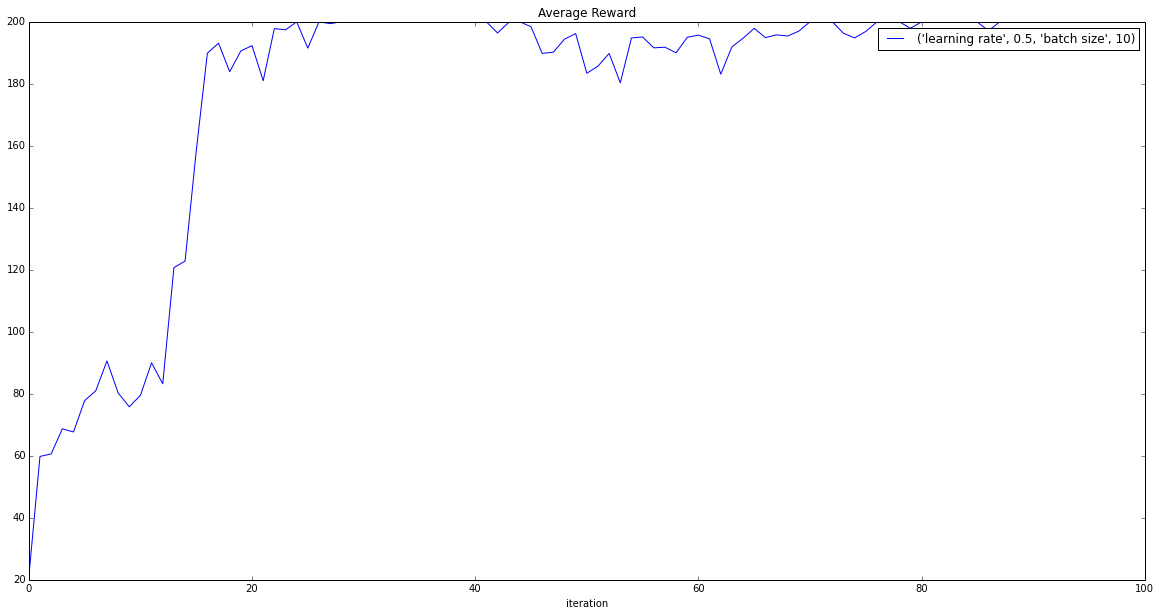

In [56]:
import gym
import time
%matplotlib inline 
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
ops.reset_default_graph()
rews = []
for lr in [0.5]:
    for r in [10]:

        env = gym.make('CartPole-v0')
        learning_rate = lr
        opt = tf.train.AdamOptimizer
        opt_value = tf.train.AdamOptimizer
        rf = ReinforceAgent(env,learning_rate=learning_rate,optimizer=opt,value_optimizer=opt_value)
        writer = tf.python.training.summary_io.SummaryWriter("./notebook",rf.sess.graph_def)
        rewards = []
        for i in xrange(100):
            #for j in xrange(r):
            states,actions,advantages,total_reward = rf.create_trajectories(env,gamma=0.99,itr=i,T=200,N=r)
            rf.sess.run(rf.optimizer, feed_dict={rf.state: states, rf.action: actions, rf.adv: advantages})
            loss = rf.sess.run(rf.loss, feed_dict={rf.state: states, rf.action: actions, rf.adv: advantages})
            loss_summ = tf.scalar_summary("loss", loss)
            #Value
            #states,actions,advantages,total_reward = rf.create_trajectories(env,gamma=0.99,horizon=200,N=10)
            rf.sess.run(rf.value_optimizer,feed_dict={rf.state_value: states, rf.value_actual: advantages})
            result = rf.sess.run([loss_summ], feed_dict={rf.state_value: states, rf.value_actual: advantages})
            summary_str = result[0]
            #acc = result
            writer.add_summary(summary_str, i)
            #writer.add_summary(merged)
            
            rewards.append(np.mean(total_reward))
            if i%10==0:
                print i,r,loss,np.mean(total_reward)
        rews.append((rewards,r,lr))
        
        #merged = tf.merge_all_summaries()
        
        

#Plotting the results
plt.figure(figsize=(20,10)) 
f, axarr = plt.subplots(1,figsize=(20,10))
for k in rews:
    label="learning rate",k[2],"batch size",k[1]
    axarr.plot(k[0],label=label)
axarr.set_title('Average Reward')
axarr.set_xlabel("iteration")
plt.legend()

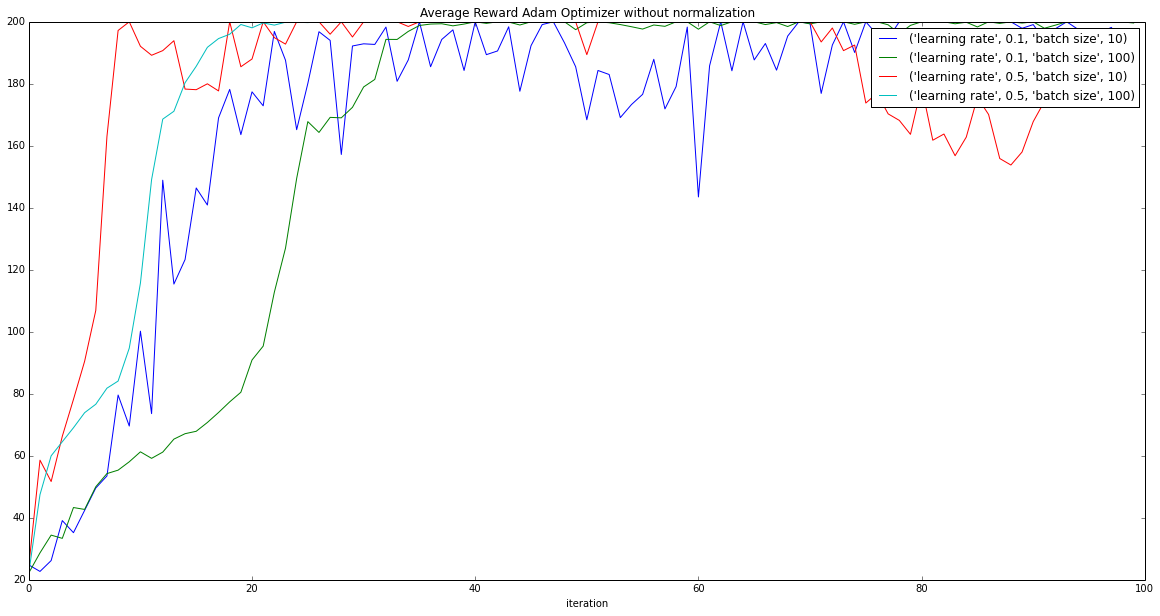

In [36]:
Adam_Without_normalizer = rews
#Plotting the results
plt.figure(figsize=(20,10)) 
f, axarr = plt.subplots(1,figsize=(20,10))
for k in rews:
    label="learning rate",k[2],"batch size",k[1]
    axarr.plot(k[0],label=label)
axarr.set_title('Average Reward Adam Optimizer without normalization')
axarr.set_xlabel("iteration")
plt.legend()

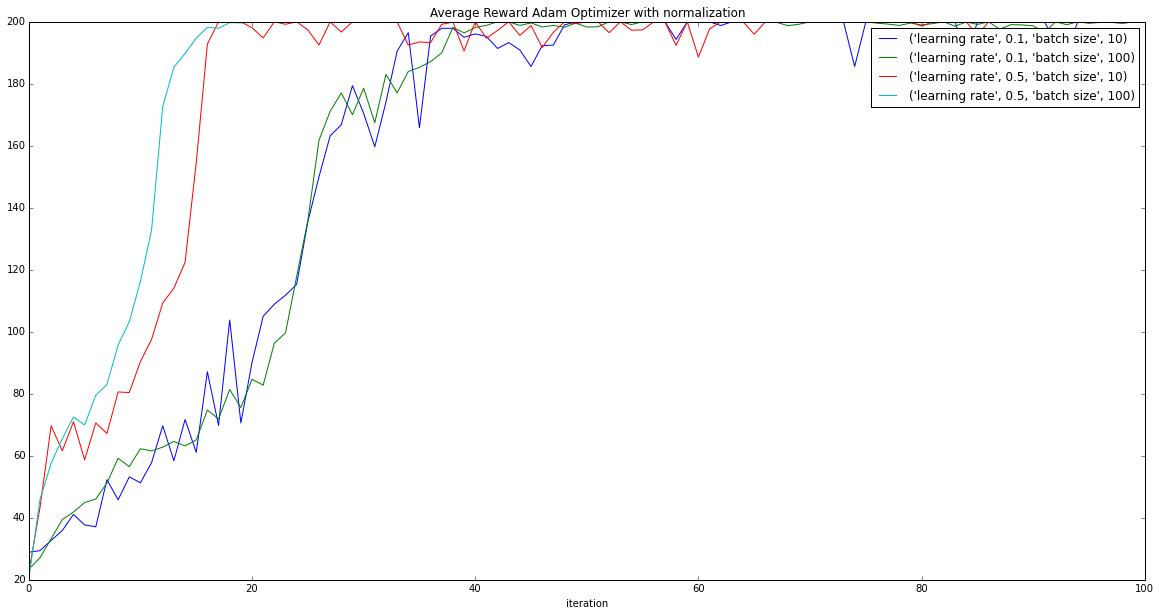

In [33]:
Adam_With_normalizer = rews
#Plotting the results
plt.figure(figsize=(20,10)) 
f, axarr = plt.subplots(1,figsize=(20,10))
for k in rews:
    label="learning rate",k[2],"batch size",k[1]
    axarr.plot(k[0],label=label)
axarr.set_title('Average Reward Adam Optimizer with normalization')
axarr.set_xlabel("iteration")
plt.legend()

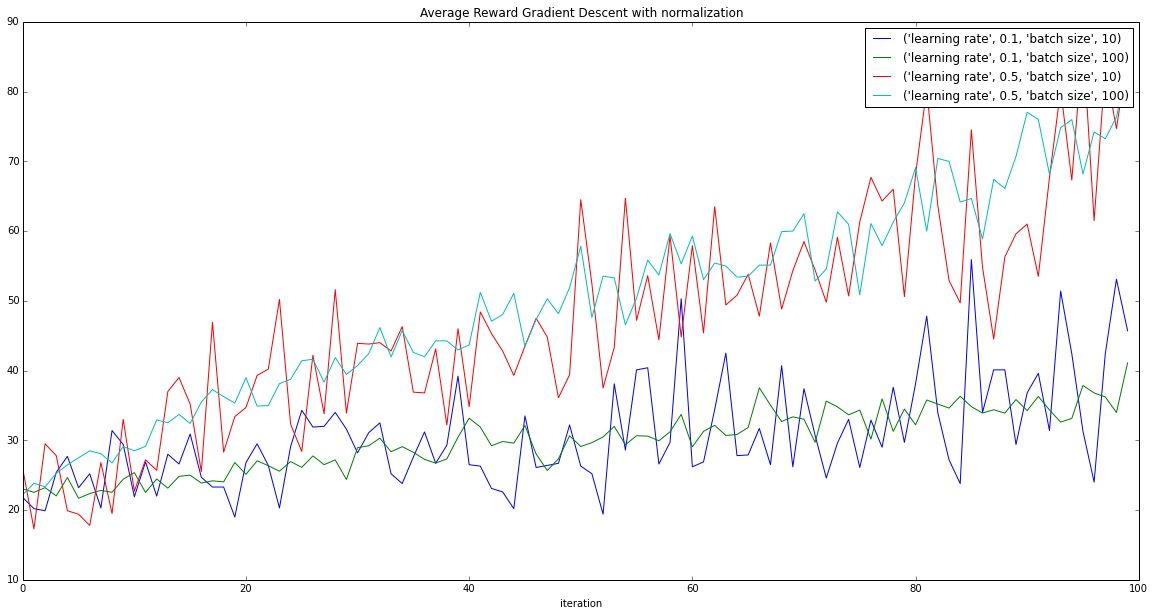

In [30]:

#Plotting the results
plt.figure(figsize=(20,10)) 
f, axarr = plt.subplots(1,figsize=(20,10))
for k in rews:
    label="learning rate",k[2],"batch size",k[1]
    axarr.plot(k[0],label=label)
axarr.set_title('Average Reward Gradient Descent with normalization')
axarr.set_xlabel("iteration")
plt.legend()